In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import dvu
import seaborn as sns
import os
import pandas as pd
from matplotlib import pyplot as plt
from os.path import join
import numpy as np
import imodelsx.process_results
import joblib
from tqdm import tqdm
dvu.set_style()

# results_dir = '../results_mar25'
# results_dir = '../results_mar27'
results_dir = '/home/chansingh/mntv1/deep-fMRI/encoding/results_mar27'
experiment_filename = '../experiments/01_fit_encoding.py'

# load the results in to a pandas dataframe
r = imodelsx.process_results.get_results_df(results_dir)
cols_varied = imodelsx.process_results.get_experiment_keys(
    r, experiment_filename)
print('experiment varied these params:', cols_varied)
# r = imodelsx.process_results.fill_missing_args_with_default(
    # r, experiment_filename)

100%|██████████| 8/8 [00:05<00:00,  1.36it/s]
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/pkg_resources/__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/lightning/fabric/__init__.py:41: Deprecated call 

experiment varied these params: ['feature_space', 'ndelays', 'nboots', 'pc_components']


In [2]:
mets = [c for c in r.columns if 'corrs_test_' in c] + \
    [c for c in r.columns if 'corrs_tune_' in c]
mets = [met for met in mets if not 'pc' in met]
d = r.groupby(cols_varied)[mets].mean()
(
    d
    .sort_values(by='corrs_test_mean', ascending=False)
    .rename(columns=lambda x: x.replace('_', ' ').replace('corrs', ''))
    .style
    .background_gradient(cmap='viridis', axis=0)
    .format(precision=3)
)

# Compare performance of a few different models

In [85]:
qa = r[(r.feature_space == 'qa_embedder-5')
       ].sort_values(by='corrs_tune_mean', ascending=False).iloc[0]
eng1000 = r[(r.feature_space == 'eng1000')].sort_values(
    by='corrs_tune_mean', ascending=False).iloc[0]

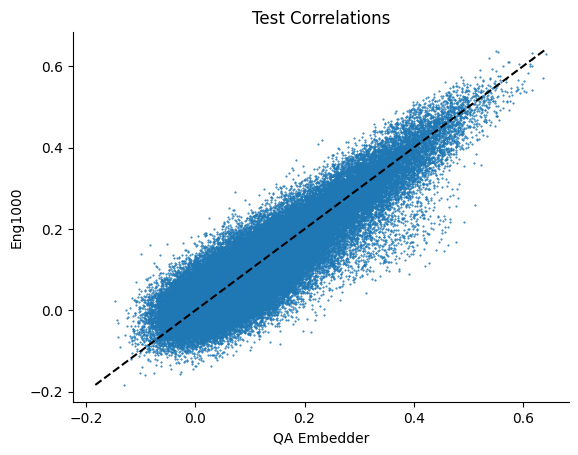

In [86]:
plt.plot(qa['corrs_test'], eng1000['corrs_test'], '.', ms=1)
plt.xlabel('QA Embedder')
plt.ylabel('Eng1000')
plt.title('Test Correlations')
m_max = max(qa['corrs_test'].max(), eng1000['corrs_test'].max())
m_min = min(qa['corrs_test'].min(), eng1000['corrs_test'].min())
plt.plot([m_min, m_max], [m_min, m_max], 'k--')
plt.show()

### Check parameters for rerunning expts (alphas, delays)

In [17]:
args = r[(r.pc_components == -1) * (r.ndelays == 8)].iloc[0]
model_params_to_save = joblib.load(
    join(args.save_dir_unique, 'model_params.pkl'))
print(args.feature_space)

qa_embedder-5


In [13]:
pd.Series(model_params_to_save['alphas_best']).value_counts()

359.381366     24742
1000.000000    21048
215.443469     16677
599.484250     15883
10.000000       6073
129.154967      4710
77.426368       2101
46.415888       1706
27.825594       1422
16.681005       1194
Name: count, dtype: int64

In [21]:
ndelays = args.ndelays
weights = model_params_to_save['weights']
assert weights.shape[0] % ndelays == 0
emb_size = weights.shape[0] / ndelays

# chunk weights by emb_size and make violion plots
weights = weights.reshape(ndelays, int(emb_size), -1)
weights = np.abs(weights.reshape(ndelays, -1))
print('means (first value is delay=1, then delay=2, ...)',
      weights.mean(axis=1), np.median(weights, axis=1))

means (first value is delay=1, then delay=2, ...) [0.00230622 0.00238972 0.0023875  0.0023021  0.00224838 0.00222139
 0.00219033 0.00220788] [0.00051652 0.00054878 0.00054529 0.0005162  0.000498   0.00048602
 0.00047744 0.00048136]


### Hybrid models

In [4]:
args = r[(r.pc_components == -1) * (r.ndelays == 8)].iloc[0]
model_params_to_save = joblib.load(
    join(args.save_dir_unique, 'model_params.pkl'))
print(args.feature_space)

qa_embedder-5


In [8]:
fit_encoding = __import__('01_fit_encoding')
story_names_train, story_names_test = fit_encoding.get_story_names(args)
stim_test_delayed, resp_test = fit_encoding.get_data(args, story_names_test)

extracting qa_embedder embs...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting 0/2: wheretheressmoke


100%|██████████| 1839/1839 [00:02<00:00, 709.10it/s]


Extracting 1/2: fromboyhoodtofatherhood


100%|██████████| 2755/2755 [00:03<00:00, 811.69it/s]


In [48]:
wt = model_params_to_save['weights']
preds_test = stim_test_delayed @ wt
# corrs_test = np.corrcoef(preds_test, resp_test, rowvar=False)
# corrs_test_mean = np.mean(corrs_test[0, 1:])
# print('means', args.corrs_test_mean, corrs_test_mean)

In [52]:
# np.corrcoef(preds_test.T[:5], resp_test.T[:5]).round(1)
# calculate correlations between each rows of preds_test with the corresponding row of resp_test
corrs_test = []
for i in tqdm(range(preds_test.shape[1])):
    corrs_test.append(np.corrcoef(
        preds_test[:, i], resp_test[:, i])[0, 1])

print(np.mean(corrs_test))
print(args.corrs_test_mean)
assert np.allclose(corrs_test, args['corrs_test'])

100%|██████████| 95556/95556 [00:53<00:00, 1771.22it/s]

0.10694734353503908
0.10694734353503908


In [53]:
args['corrs_test']

array([ 0.01523068,  0.06518431, -0.01621583, ..., -0.02024097,
       -0.02566768, -0.06186632])

In [54]:
corrs_test

[0.015230680397330842,
 0.06518430923126266,
 -0.016215831054033573,
 -0.037845315588296055,
 -0.0635083164659215,
 -0.02423712711521713,
 -0.001500353892862577,
 0.0492461859900983,
 -0.053168471009801536,
 0.003203756671994838,
 0.02914325833764363,
 -0.02662183331683751,
 0.0038693099167201503,
 -0.06282633674586748,
 -0.029678027151855205,
 0.0486976663388747,
 0.008175755273584535,
 0.055063277862998666,
 -0.019032751278513192,
 -0.0014001546203361687,
 0.038688898592551306,
 0.009137550358870058,
 0.04733972305304183,
 0.04505056875531129,
 -0.019885510681800788,
 -0.05856266820960434,
 -0.044534784582255876,
 -0.004586886738898506,
 -0.0010622019851671443,
 0.06468950524975468,
 -0.031177435403635545,
 0.046630454765965564,
 0.044564510267558415,
 -0.004064102168431102,
 0.05140975449158061,
 0.016845097606264025,
 -0.00796599595534989,
 0.012996844644024725,
 0.033344142199816566,
 -0.02638189632801036,
 0.08819890736509212,
 0.060901724000340024,
 0.00940186982776777,
 0.02685

# Analyze

### Evaluate PC models

In [ ]:
wt = model_params_to_save['weights']
preds_pc = stim_test_delayed @ wt
preds_voxels = pca.inverse_transform(
    scaler_test.inverse_transform(preds_pc)
)  # (n_trs x n_voxels)

In [ ]:
corrs_test = fit_encoding.evaluate_pc_model_on_each_voxel(
    args, stim_test_delayed, resp_test,
    model_params_to_save, pca, scaler_test)

In [ ]:
wt = model_params_to_save['weights']

# multiply
preds_pc = stim_test_delayed @ wt
preds_pc_unscaled = preds_pc * scaler_test.scale_ + scaler_test.mean_
preds_voxels2 = preds_pc_unscaled @ pca.components_ + pca.mean_

# rewrite the above as a multiplication of a single weight matrix
preds_voxels2 = (stim_test_delayed @ wt * scaler_test.scale_ +
                 scaler_test.mean_) @ pca.components_ + pca.mean_
weight_full = wt * scaler_test.scale_ @ pca.components_
bias_full = scaler_test.mean_ @ pca.components_ + pca.mean_
preds_voxels2 = stim_test_delayed @ weight_full + bias_full

assert np.allclose(preds_voxels, preds_voxels2)

In [ ]:
assert corrs_test.mean() == args.corrs_test_mean